# crossfit open 2018 supervised learning
In the previous notebook `open_182a_bayesian_regression`, we used the athlete profile benchmarks to perform regression on workout 18.2a. This notebook will focus on regressing the entire Open. First, we'll use the benchmarks to regress each open workout and analyze the results. Afterwards, we'll attempt to find redundancies in the Open. To predict some Open workout *x*, we'll use the other Open workouts *along with* the benchmarks to attempto better regress Open scores.

## imports
Here we'll import all the modules we'll make use of thoughout this notebook.

In [58]:
#working with ids to implement custom train/test splitting
import numpy as np
#working locally with data (dataframes)
import pandas as pd
#data scaling, learning agents
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import train_test_split
#plotting
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

#custom modules
import sys
sys.path.insert(0, "../custom_modules/")
#seaborn/matplotlib styling
import seaborn_styler as sbs

## reading in the data
The data has previously been filtered/collected from a database in another learning notebook and written to CSV. We'll grab that data here.

In [2]:
raw_df = pd.read_csv("../sample_data/sample_pure_division_18.csv").drop(["Unnamed: 0"], axis=1)
raw_df.head(3)

,id,leaderboard_18_1_reps,leaderboard_18_2_time_secs,leaderboard_18_2a_weight_lbs,leaderboard_18_3_time_secs,leaderboard_18_4_time_secs,leaderboard_18_5_reps,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
0,86,328,651,207,1373,637,77,77,225,335,265,210,415,32,226,174,496,1287,64,1325
1,93,309,480,235,1548,642,94,72,205,305,235,185,355,45,220,154,493,1500,62,1239
2,1636,402,316,260,1148,577,123,70,200,400,285,215,485,67,138,108,429,1056,58,1219


## grabbing columns of interest
This notebook will work on performing machine learning for the open workouts. These learning tasks will occur in 2 forms: with the other remaining open workouts as features, and without (only benchmarks). We'll start by extracting these Open workouts.

In [3]:
open_keys = list(raw_df.columns[1:7])
open_keys

['leaderboard_18_1_reps',
 'leaderboard_18_2_time_secs',
 'leaderboard_18_2a_weight_lbs',
 'leaderboard_18_3_time_secs',
 'leaderboard_18_4_time_secs',
 'leaderboard_18_5_reps']

## scaling the data
We'll scale this data using scikit-learn's `StandardScaler`, which scales each feature independently to unit variance.

In [4]:
x = [1,2,3]
x.remove(2)
x

[1, 3]

In [5]:
scaled_data = StandardScaler().fit_transform(raw_df.drop(["id"], axis=1))
df = pd.concat(
    [
        raw_df[["id"]],
        #all columns but id in the columns=... statement
        pd.DataFrame(scaled_data, columns=list(raw_df.columns)[1:])
    ],
    axis=1
)
df.head(3)

,id,leaderboard_18_1_reps,leaderboard_18_2_time_secs,leaderboard_18_2a_weight_lbs,leaderboard_18_3_time_secs,leaderboard_18_4_time_secs,leaderboard_18_5_reps,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
0,86,0.158430,2.065809,-1.132659,0.328936,0.414922,-0.546937,1.103061,1.694207,-0.477036,0.182866,0.285815,-0.454332,-0.581332,-0.004048,0.066970,-0.473635,-0.387131,-0.333732,0.105375
1,93,-0.181246,0.266425,-0.359136,0.941889,0.453402,-0.061351,0.336881,0.736628,-0.979968,-0.599759,-0.438017,-1.409255,0.326252,-0.077476,-0.215067,-0.506319,0.265119,-0.495560,-0.434557
2,1636,1.481380,-1.459299,0.331510,-0.459145,-0.046834,0.767001,0.030409,0.497233,0.612652,0.704616,0.430581,0.659746,1.862164,-1.080997,-0.863752,-1.203567,-1.094500,-0.819216,-0.560122


## splitting the data based on features
So we know there will be 6 different dependents (18.1, 18.2, 18.2a, 18.3, 18.4, 18.5), but each of these will have 2 feature sets, 1 for each learning task (benchmarks, benchmarks and other Open workouts). We'll do this separation of data iteratively below.

In [6]:
datasets = {
    #18.1
    #"1_limited": [features_1_limited_df, targets_1_limited_df],
    #"1_full": [features_1_limited_df, targets_1_limited_df],
    #"2_limited": ...
}
#iterate over each dependent
for i in range(len(open_keys)):
    #limited dataset
    datasets["{}_limited".format(i)] = [
        #features (only benchmarks)
        df.drop(open_keys, axis=1),
        #targets
        df[["id", open_keys[i]]]
    ]
    #full dataset
    datasets["{}_full".format(i)] = [
        #features (benchmarks and other open workouts)
        df.drop(open_keys[i], axis=1),
        #targets
        df[["id", open_keys[i]]]
    ]

In [7]:
#only benchmark features
datasets["0_limited"][0].head(3)

,id,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
0,86,1.103061,1.694207,-0.477036,0.182866,0.285815,-0.454332,-0.581332,-0.004048,0.066970,-0.473635,-0.387131,-0.333732,0.105375
1,93,0.336881,0.736628,-0.979968,-0.599759,-0.438017,-1.409255,0.326252,-0.077476,-0.215067,-0.506319,0.265119,-0.495560,-0.434557
2,1636,0.030409,0.497233,0.612652,0.704616,0.430581,0.659746,1.862164,-1.080997,-0.863752,-1.203567,-1.094500,-0.819216,-0.560122


In [8]:
#only benchmark targets
datasets["0_limited"][1].head(3)

,id,leaderboard_18_1_reps
0,86,0.158430
1,93,-0.181246
2,1636,1.481380


In [9]:
#benchmarks and other open workouts features
datasets["0_full"][0].head(3)

,id,leaderboard_18_2_time_secs,leaderboard_18_2a_weight_lbs,leaderboard_18_3_time_secs,leaderboard_18_4_time_secs,leaderboard_18_5_reps,height_in,weight_lbs,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs,max_pull_ups,fran_time_secs,grace_time_secs,helen_time_secs,filthy_50_time_secs,sprint_400_m_time_secs,run_5_km_time_secs
0,86,2.065809,-1.132659,0.328936,0.414922,-0.546937,1.103061,1.694207,-0.477036,0.182866,0.285815,-0.454332,-0.581332,-0.004048,0.066970,-0.473635,-0.387131,-0.333732,0.105375
1,93,0.266425,-0.359136,0.941889,0.453402,-0.061351,0.336881,0.736628,-0.979968,-0.599759,-0.438017,-1.409255,0.326252,-0.077476,-0.215067,-0.506319,0.265119,-0.495560,-0.434557
2,1636,-1.459299,0.331510,-0.459145,-0.046834,0.767001,0.030409,0.497233,0.612652,0.704616,0.430581,0.659746,1.862164,-1.080997,-0.863752,-1.203567,-1.094500,-0.819216,-0.560122


In [10]:
#benchmarks and other open workouts targets
datasets["0_full"][1].head(3)

,id,leaderboard_18_1_reps
0,86,0.158430
1,93,-0.181246
2,1636,1.481380


## splitting ids into training and testing
We'll split the data into training/testing sets on a per-id basis.

In [11]:
training_size = .8
ids = df["id"].values
train_ids = np.random.choice(ids, size=int(len(ids) * training_size), replace=False)
train_ids

array([  60290,   34708,   11623,  686958,   19485,  395596,   99852,
        114073,  239786,  248843,    2649,   17742,    2808,   26515,
          3583,  549326,   36494,    4407,   16495,  535071,  114032,
          6572,   42521,    4880,   61901,   13909,    5457,  185926,
        665812,  273334,  413402,  241391,  553329,  467892,  254219,
        254097,   25471,  150336,    8913,  201020,   33625,    2956,
        325933,  278757,   10858,   33079,   50334,   40470, 1081677,
        411410,  565129,  906114,  124881,  258248,  237949,   32245,
        256514,   39995,   71831,    7117,   36588,    9217,    3805,
        104910,  467774,   98711,   31660,  110883,    4842,  396150,
        759578,    1665,  190322,   10307,   52740,   98737,  119829,
          5223,   53236,   28443,  130502,   13060,  169827,  100941,
        245977,   50347,    5229,  355154,  252991,    5238,  513810,
          5443,   99303,   37519,   96065,    4068,   35683,   95883,
          9858,   44

In [12]:
#get ids that aren't in train_ids
test_ids = np.setdiff1d(ids, train_ids)
test_ids

array([  1636,   2073,   3000,   3855,   4231,   4620,   4645,   5133,
         5287,   5424,   5836,   6279,   6467,   6740,   8428,   8496,
         8851,   9799,   9906,  11066,  12242,  12329,  13006,  16443,
        16649,  17977,  18201,  18276,  22661,  23447,  24366,  24599,
        27065,  28501,  28689,  30310,  33216,  33457,  42024,  42059,
        43310,  50251,  51066,  59774,  60346,  60413,  69843,  72068,
        78241,  79207,  79664,  84296,  84783,  91497,  96339, 102064,
       102993, 105934, 108971, 111613, 112065, 113902, 128316, 136104,
       141432, 158452, 159558, 170731, 172875, 182631, 190858, 202371,
       208605, 214125, 227272, 240339, 246455, 247271, 292529, 298558,
       302852, 317649, 325664, 332729, 379392, 412551, 458674, 468457,
       474048, 503903, 510134, 511412, 518554, 519766, 558738, 678723,
       682487, 706259, 724020, 750645, 901317, 918639, 956598], dtype=int64)

## fitting learners to each dataset
For each dataset we'll fit 3 different types of learners: [bayesian regressors](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge), [neural networks](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor), and [random forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html). We'll iteratively fit and store a learner of each type for each of the 12 datasets.

### model parameters
We'll not tune these models individually for each dataset. There is a great amount of shared data between them, and although there may be some small gains for each learning task if tuned individually, this tuning will not be performed. The parameters used for each model will be set below.

In [110]:
#default parameters
random_state = 0
#bayes

#neural net
max_iter = 400
#random forest
max_depth = 5
min_samples_leaf = 3

In [111]:
datasets["{}_limited".format(0)][1].head(3)

,id,leaderboard_18_1_reps
0,86,0.158430
1,93,-0.181246
2,1636,1.481380


### fitting learners
The learners will be fit to each dataset and assigned to the `mlmap` below.

In [112]:
mlmap={}
#iterate over each dependent (6 total)
for i in range(len(open_keys)):
    #get keys
    data_keys = list(map(lambda x: x.format(i), ["{}_limited", "{}_full"]))
    
    #for each dataset (2 total)
    for j in range(len(data_keys)):
        #make kvp entry
        mlmap[data_keys[j]] = {
            #train: training features/targets,
            #test: testing features/targets,
            #learners: learners fit to training set, meant to be tested on testing set
        }
        
        #get dataset
        tmp_dfs = datasets[data_keys[j]]
        
        #the only difference between the next 2 list assignments is
        #".isin(train_ids)" and ".isin(test_ids)"
        #- likely candidate for iteration
        #training
        mlmap[data_keys[j]]["train"] = [
            #features
            tmp_dfs[0][tmp_dfs[0]["id"].isin(train_ids)],
            #targets
            tmp_dfs[1][tmp_dfs[1]["id"].isin(train_ids)]
        ]
        #testing
        mlmap[data_keys[j]]["test"] = [
            #features
            tmp_dfs[0][tmp_dfs[0]["id"].isin(test_ids)],
            #targets
            tmp_dfs[1][tmp_dfs[1]["id"].isin(test_ids)]
        ]
        
        #fit 3 learners to training data
        training_set = mlmap[data_keys[j]]["train"]
        tmp_x = training_set[0].drop(["id"], axis=1)
        tmp_y = np.ravel(training_set[1].drop(["id"], axis=1))
        mlmap[data_keys[j]]["learners"] = [
            #bayes
            BayesianRidge(
                compute_score=True,
            ).fit(tmp_x, tmp_y),
            
            #neural network
            MLPRegressor(
                #the below -1 factors are to remove the ID column counts
                hidden_layer_sizes=(
                    #input layer (this is A LOT simpler than it looks)
                    len(training_set[0].columns) - 1,
                    #hidden layer (https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa)
                    #mean(input layer neurons and output layer neurons)
                    #= (len(training_set[1].columns) - 1 + len(training_set[1].columns) - 1) * .5
                    #= (len(training_set[1].columns) - 1 + 2 - 1) * .5
                    #= len(training_set[1].columns) * .5
                    int(
                        np.ceil(
                            len(training_set[1].columns) * .5
                        )
                    ),
                    #output layer
                    1
                ),
                #maximum iterations to perform before stopping training
                max_iter=max_iter,
                #random state
                random_state=random_state
            ).fit(tmp_x, tmp_y),
            
            #random forest
            RandomForestRegressor(
                #max depth
                max_depth=max_depth,
                #minimum leaf samples required to not prune
                min_samples_leaf = min_samples_leaf,
                #random state
                random_state=random_state
            ).fit(tmp_x, tmp_y)
        ]

## plotting predictions vs. ground truth
Before scoring the learners, we can see visually how each performed vs. the ground truth (how athletes actually performed in the workouts).

First, we'll get the dictionary keys for each dataset.

In [113]:
#data keys
data_keys = []
for i in range(len(open_keys)):
    data_keys += list(map(lambda x: x.format(i), ["{}_limited", "{}_full"]))
", ".join(data_keys)

'0_limited, 0_full, 1_limited, 1_full, 2_limited, 2_full, 3_limited, 3_full, 4_limited, 4_full, 5_limited, 5_full'

### plotting
Below we'll actually plot the data using Matplotlib. However, the seaborn styling used in this project *may* require seaborn, so both seaborn and the styling module have been imported above. The styling should be run before plotting to set the graph style, and it only needs to be run once *or* whenever the style is changed and it's desired to revert back to the default styling.

In [114]:
#double figure width
#the notebook will limit this size...so it'll probably be less than double
if sbs.figure_size == [8, 6]:
    sbs.figure_size = [sbs.figure_size[0] * 2, sbs.figure_size[1]]
sbs.stylize()

In [115]:
color_map = {
    "real": "#00ccff",
    "bayesian": "#ffcc00",
    "neuralnet": "#ff0066",
    "randomforest": "#99ff33"
}

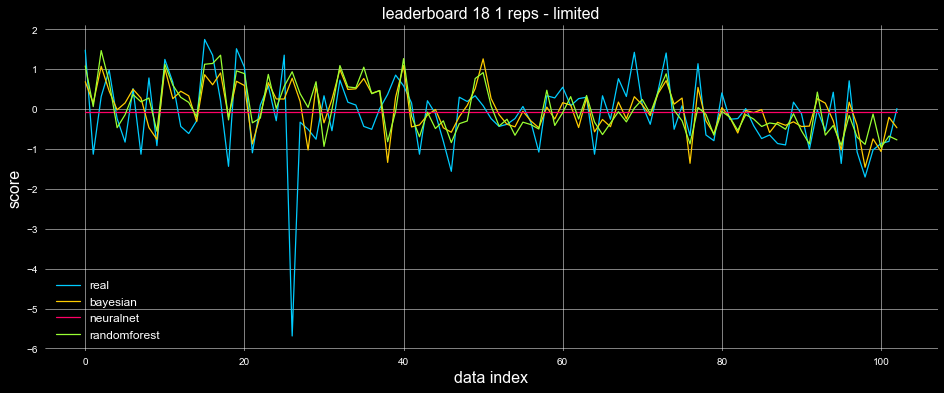

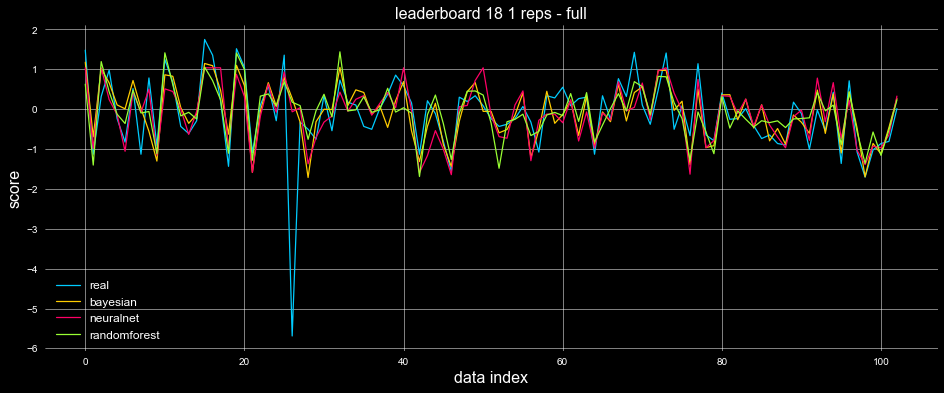

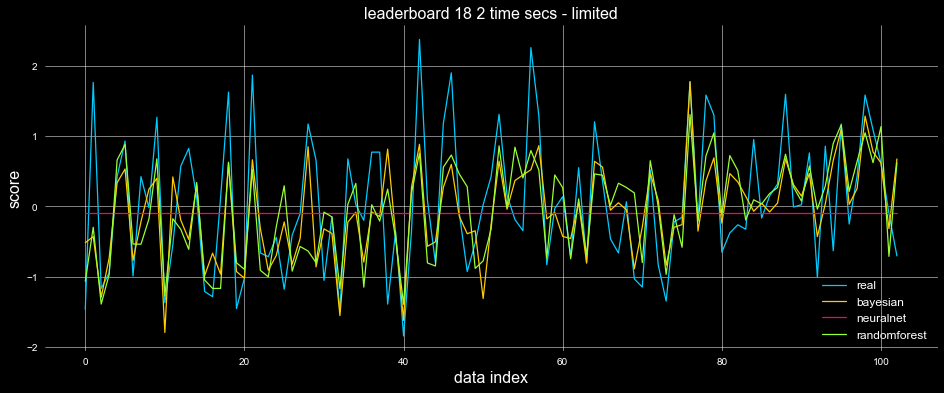

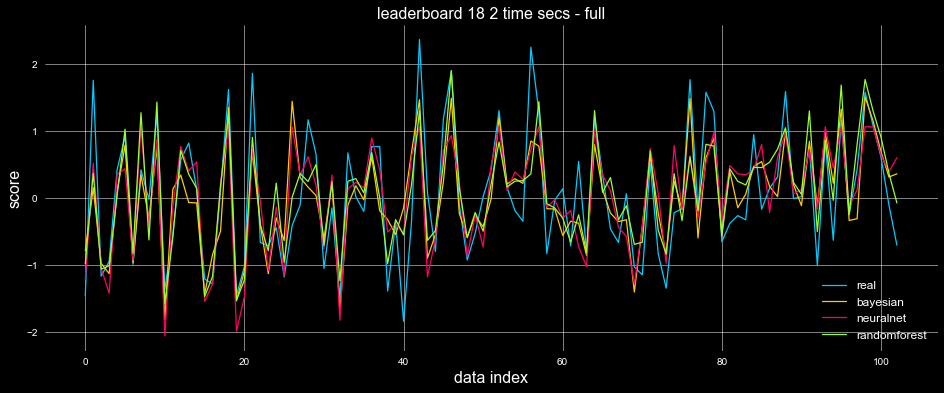

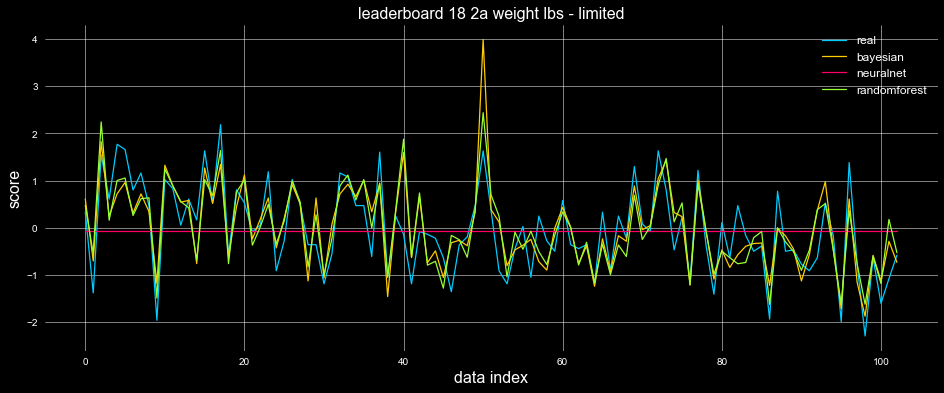

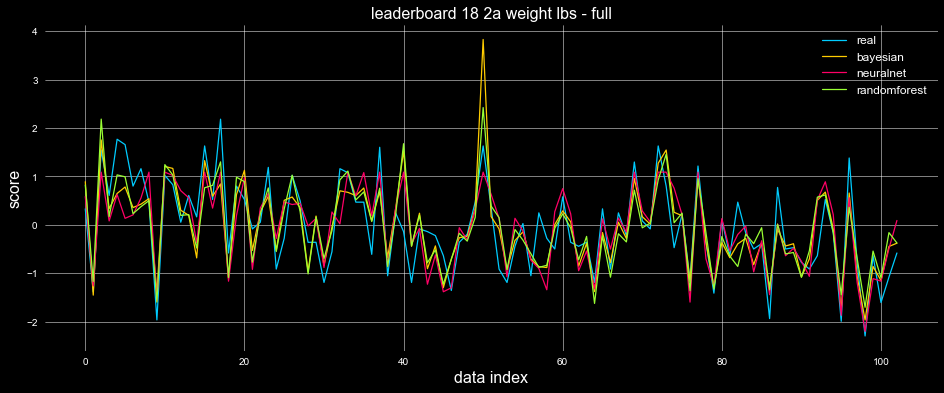

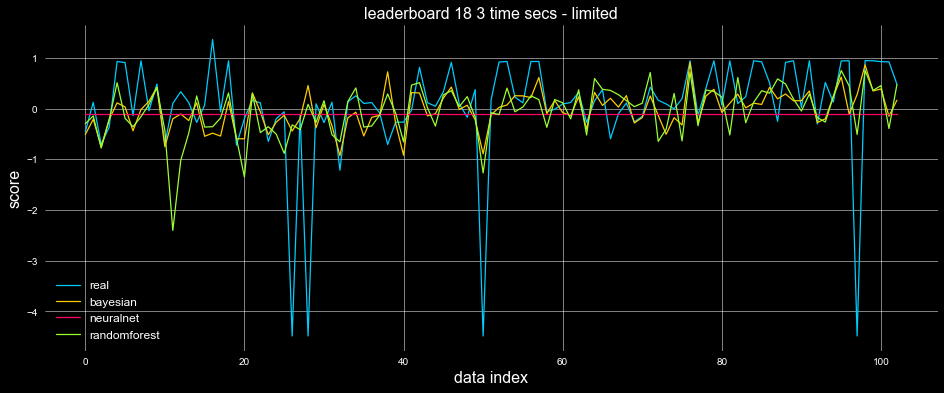

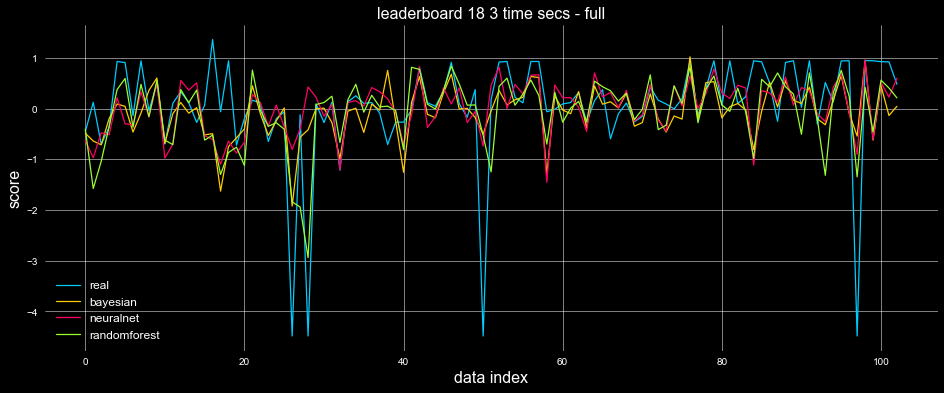

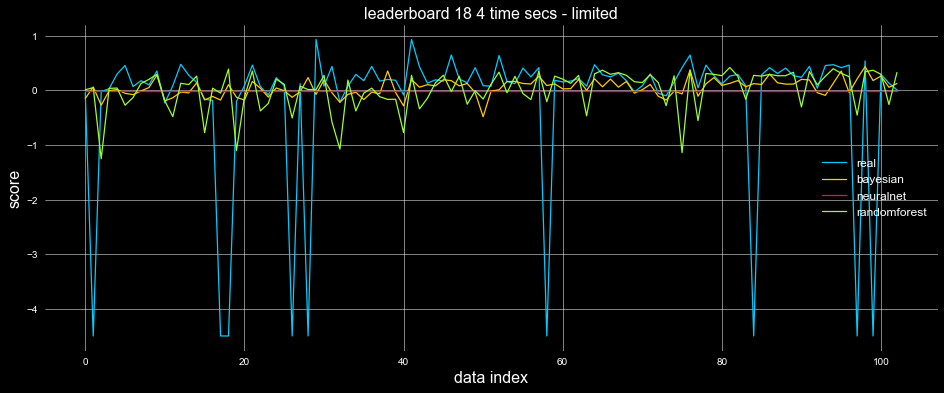

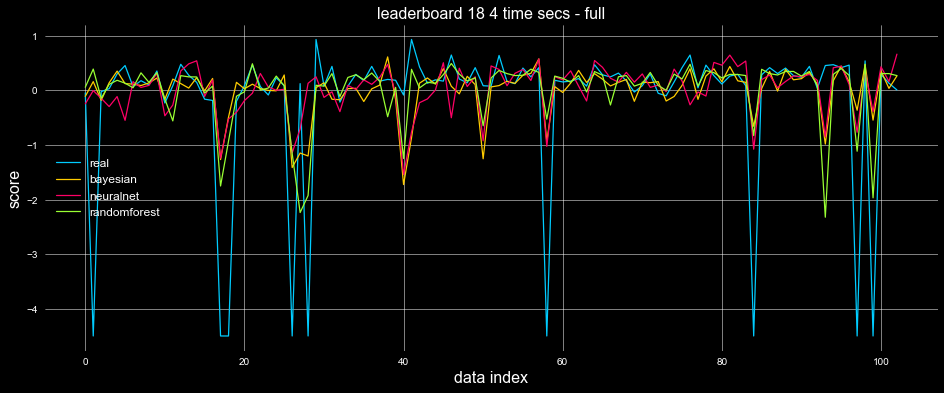

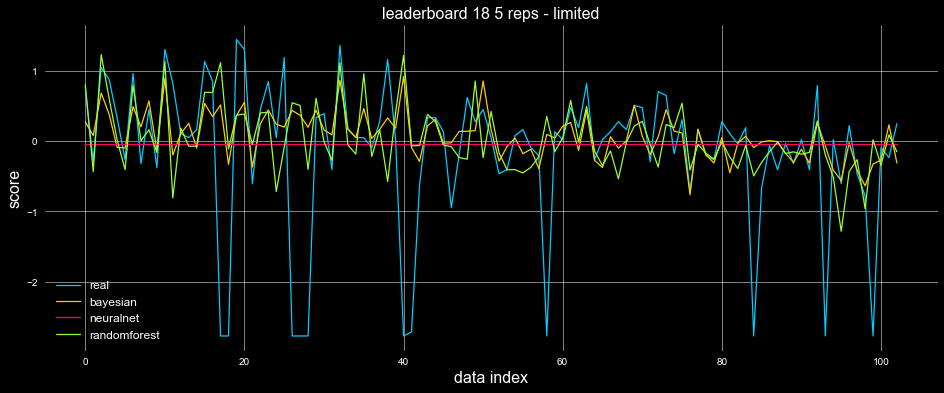

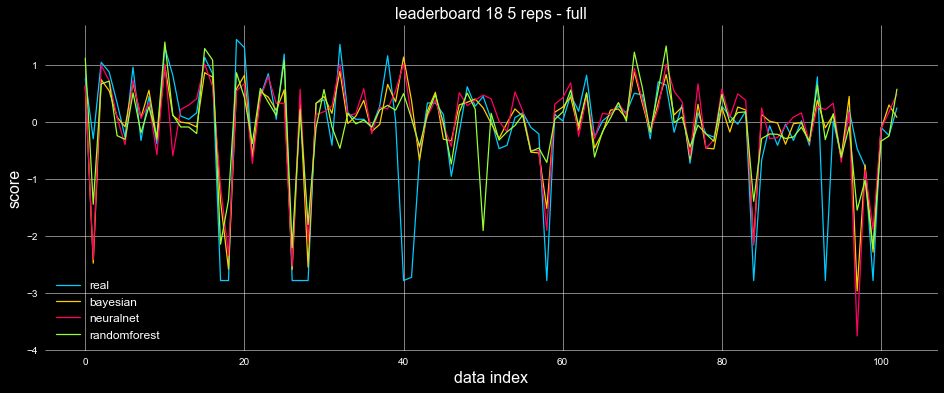

In [118]:
#for each dataset
for dk in data_keys:
    #get testing targets
    targets = mlmap[dk]["test"][1]
    #reformat
    #https://stackoverflow.com/questions/12555323/adding-new-column-to-existing-dataframe-in-python-pandas?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
    targets = targets.assign(num=pd.Series(np.arange(len(targets))).values).drop(["id"], axis=1)
    targets = targets[["num", targets.columns[0]]]
    
    #plot ground truth
    plt.plot(
        targets.columns[0],
        targets.columns[1],
        data=targets,
        label="real",
        color=color_map["real"]
    )
    #plot predictions
    learners = mlmap[dk]["learners"]
    #learner predictions dataframe
    preds = pd.DataFrame(targets[["num"]])
    #bayesian
    preds = preds.assign(bayesian=learners[0].predict(mlmap[dk]["test"][0].drop(["id"], axis=1)))
    #neural net
    preds = preds.assign(neuralnet=learners[1].predict(mlmap[dk]["test"][0].drop(["id"], axis=1)))
    #random forest
    preds = preds.assign(randomforest=learners[2].predict(mlmap[dk]["test"][0].drop(["id"], axis=1)))
    #creating visuals
    for c in list(preds.columns[1:]):
        plt.plot(
            preds.columns[0],
            c,
            data=preds,
            label=c,
            color=color_map[c]
        )
    
    plt.legend(loc="best")
    plt.xlabel("data index")
    plt.ylabel("score")
    plt.title("{}".format(targets.columns[-1].replace("_", " ") + " - " + dk.split("_")[-1]))
    plt.show()

In [117]:
pd.concat([preds, targets[targets.columns[-1]]], axis=1)

,num,bayesian,neuralnet,randomforest,leaderboard_18_1_reps
2,0,0.688680,-0.061173,1.085127,1.481380
8,1,0.149993,-0.061173,0.066469,-1.128765
19,2,1.076322,-0.061173,1.470828,0.319329
26,3,0.457757,-0.061173,0.684978,0.980804
31,4,-0.016085,-0.061173,-0.463365,-0.234880
34,5,0.157017,-0.061173,-0.138391,-0.824844
35,6,0.501859,-0.061173,0.368340,0.515984
39,7,0.278352,-0.061173,0.186128,-1.128765
43,8,-0.461499,-0.061173,0.279980,0.784149
48,9,-0.756873,-0.061173,-0.553413,-0.914232
